# Models and Evaluation

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

ALL_DATA = False
USE_SMOTE = True

if ALL_DATA: data = pd.read_csv('data_processed/complete/enc_data.csv')
else: data = pd.read_csv('data_processed/complete/data_selected.csv').drop('loan_id', axis=1)

display(data.head())

,loan_amount,loan_payments,has_disponent,mean_balance,min_balance,negative_balance,monthly_diff,a_freq_monthly_issuance,a_freq_weekly_issuance,status
0,96396,8033,False,12250.000000,1100.0,0.0,6700,0.0,1.0,-1
1,165960,4610,False,52083.859459,700.0,0.0,14733,1.0,0.0,1
2,127080,2118,False,30060.954167,800.0,0.0,-6859,1.0,0.0,1
3,105804,2939,False,41297.480000,1000.0,0.0,-11054,1.0,0.0,1
4,274740,4579,False,57188.211111,600.0,0.0,-30531,0.0,1.0,1


In [2]:
def get_features(df):
    return df.drop('status', axis=1)
def get_target(df):
    return df['status']

results = {}

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

def make_pipeline(classifier, smote = False):
    steps = []
    if smote: steps.append(['smote', SMOTE(random_state=1, sampling_strategy=1.0)])
    steps.append(['classifier', classifier])
    return imbpipeline(steps = steps)

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

stratified_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [5]:
from sklearn.model_selection import cross_validate

def cross_validation(name, model, df=data, cv=stratified_kfold):
    model = make_pipeline(model, smote=USE_SMOTE)
    scores = cross_validate(model, get_features(df), get_target(df), scoring='roc_auc', cv=cv)['test_score']

    results[name] = scores
    print(name, scores.mean(), scores.std())

### Algorithms

In [6]:
from sklearn.tree import DecisionTreeClassifier
cross_validation('DT',
    DecisionTreeClassifier(
        criterion= "entropy",
        max_depth= 17,
        max_features= "sqrt",
        max_leaf_nodes= 13,
        min_samples_leaf= 4,
        min_samples_split= 2
    ),
)

DT 0.7444033695349487 0.0954392877133244


In [7]:
from sklearn.neighbors import KNeighborsClassifier
cross_validation('KNN',
    KNeighborsClassifier(
        algorithm= "auto",
        n_neighbors= 11,
        weights= "distance"
    ),
)

KNN 0.7131207648751509 0.0412488506713697


In [8]:
from sklearn.neural_network import MLPClassifier
cross_validation('MLP',
    MLPClassifier(),
)

MLP 0.6861967418546365 0.08575864632584651


In [9]:
from sklearn.naive_bayes import GaussianNB
cross_validation('GNB',
    GaussianNB(),
)

GNB 0.7332004780469693 0.09299573140320809


In [10]:
from sklearn.svm import SVC
cross_validation('SVM',
    SVC(
        probability=True,
        max_iter=10000,
        C= 1,
        coef0= 0.0,
        degree= 3,
        gamma= 'scale',
        kernel= 'poly',
        shrinking= True,
        tol= 0.0001
    ),
)

SVM 0.6670746310219993 0.09718514252980659


In [11]:
from sklearn.linear_model import LogisticRegression
cross_validation('LR',
    LogisticRegression(
        max_iter=10000,
        C= 100,
        fit_intercept= False,
        solver= 'newton-cg',
        tol= 0.001
    )
)

/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/rikenunes8/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3/dist-packages/scipy/optimize/

LR 0.8208716235032025 0.04817348064493897


/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/rikenunes8/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [12]:
from sklearn.ensemble import RandomForestClassifier
cross_validation('RF',
    RandomForestClassifier(
        criterion= 'entropy',
        max_depth= 18,
        max_features= 'sqrt',
        n_estimators= 40
    ),
)

RF 0.8367889631486123 0.06580207915086003


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
cross_validation('GB',
    GradientBoostingClassifier(),
)

GB 0.8379467186484729 0.06953290420099684


### Evaluation

/home/rikenunes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/rikenunes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


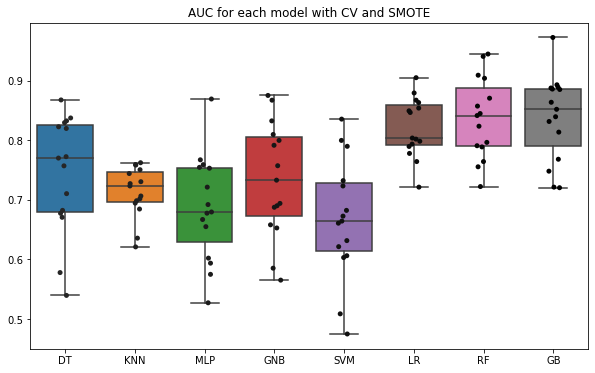

In [14]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sb.boxplot(data=pd.DataFrame(results))
sb.stripplot(data=pd.DataFrame(results), color='black')
plt.title('AUC for each model with CV and SMOTE')
plt.show()

In [15]:
for name, scores in results.items():
    print(name, scores.mean(), scores.std())

DT 0.7444033695349487 0.0954392877133244
KNN 0.7131207648751509 0.0412488506713697
MLP 0.6861967418546365 0.08575864632584651
GNB 0.7332004780469693 0.09299573140320809
SVM 0.6670746310219993 0.09718514252980659
LR 0.8208716235032025 0.04817348064493897
RF 0.8367889631486123 0.06580207915086003
GB 0.8379467186484729 0.06953290420099684
